## Identificazione dipendenti "a rischio abbandono"

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import time

from numpy.random import seed

In [2]:
# controllo la versione di Tensorflow
print(tf.__version__)

2.2.0


In [31]:
# to remove some warnings

# TF2 way to reduce logging
# this remove also INFO, verify if needed
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [45]:
# faccio i settaggi necessari per l'ambiente con GPU a disposizione
#

DEVICE = 'GPU'

if DEVICE == "GPU":
    
    # controllo quante GPU ho a disposizione
    # per settare la corretta "strategia" (distributed, ?)
    n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", n_gpu)
    
    if n_gpu > 1:
        print("Using strategy for multiple GPU")
        strategy = tf.distribute.MirroredStrategy()
    else:
        print('Standard strategy for GPU...')
        strategy = tf.distribute.get_strategy()

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

print(f'Replicas: {REPLICAS}')

Num GPUs Available:  1
Standard strategy for GPU...
Replicas: 1


In [4]:
# carico il file dati

FILE_ORIG = '/home/datascience/ads-examples/oracle_data/orcl_attrition.csv'

dati_orig = pd.read_csv(FILE_ORIG) 

dati_orig.head()

,Age,Attrition,TravelForWork,SalaryLevel,JobFunction,CommuteLength,EducationalLevel,EducationField,Directs,EmployeeNumber,...,WeeklyWorkedHours,StockOptionLevel,YearsinIndustry,TrainingTimesLastYear,WorkLifeBalance,YearsOnJob,YearsAtCurrentLevel,YearsSinceLastPromotion,YearsWithCurrManager,name
0,42,Yes,infrequent,5054,Product Management,2,L2,Life Sciences,1,1,...,80,0,8,0,1,6,4,0,5,Tracy Moore
1,50,No,often,1278,Software Developer,9,L1,Life Sciences,1,2,...,80,1,10,3,3,10,7,1,7,Andrew Hoover
2,38,Yes,infrequent,6296,Software Developer,3,L2,Other,1,4,...,80,0,7,3,3,0,0,0,0,Julie Bell
3,34,No,often,6384,Software Developer,4,L4,Life Sciences,1,5,...,80,0,8,3,3,8,7,3,0,Thomas Adams
4,28,No,infrequent,2710,Software Developer,3,L1,Medical,1,7,...,80,1,6,3,3,2,2,2,2,Johnathan Burnett


In [5]:
dati_orig.columns

Index(['Age', 'Attrition', 'TravelForWork', 'SalaryLevel', 'JobFunction',
       'CommuteLength', 'EducationalLevel', 'EducationField', 'Directs',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'WeeklyWorkedHours', 'StockOptionLevel',
       'YearsinIndustry', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsOnJob', 'YearsAtCurrentLevel', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'name'],
      dtype='object')

In [6]:
# elimino alcune colonne non utili per l'addestramento del modello
columns_to_drop = ['EmployeeNumber','name','Over18']

dati = dati_orig.drop(columns_to_drop, axis = 1)

In [7]:
dati.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
TravelForWork               1470 non-null object
SalaryLevel                 1470 non-null int64
JobFunction                 1470 non-null object
CommuteLength               1470 non-null int64
EducationalLevel            1470 non-null object
EducationField              1470 non-null object
Directs                     1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome               1470 non-null int64
MonthlyRate          

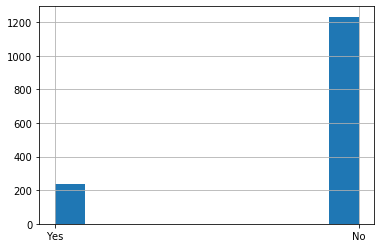

In [44]:
# esamino la percentuale di attrition
dati['Attrition'].hist();

In [ ]:
# il dataset è sbilanciato, relativamente pochi attrition
# tenuto conto che vogliamo prevedere chi è a rsichio attrition è una cosa da gestire (vedi Focal Loss)

In [8]:
# devo provevedere a codificare le colonne object nella lista precedente: TravelForWork, JobFunction, EducationalLevel, EducationField, 
# Gender, JobRole, MaritalStatus, OverTime
# devo ricorrere ad una codifica one-hot

# valori multipli
columns_to_code_multiple = ['TravelForWork', 'JobFunction', 'EducationalLevel', 'EducationField', 'JobRole', 'MaritalStatus']
# due soli valori
columns_to_code_double = ['Attrition', 'OverTime', 'Gender']

dati_coded = pd.get_dummies(dati, columns = columns_to_code_multiple)
dati_coded = pd.get_dummies(dati_coded, columns = columns_to_code_double, drop_first=True)

In [9]:
# verifico
dati_coded.head()

,Age,SalaryLevel,CommuteLength,Directs,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Attrition_Yes,OverTime_Yes,Gender_Male
0,42,5054,2,1,2,94,3,2,4,5993,...,0,0,1,0,0,0,1,1,1,0
1,50,1278,9,1,3,61,2,2,2,5130,...,0,1,0,0,0,1,0,0,0,1
2,38,6296,3,1,4,92,2,1,3,2090,...,0,0,0,0,0,0,1,1,1,1
3,34,6384,4,1,4,56,3,1,3,2909,...,0,1,0,0,0,1,0,0,1,0
4,28,2710,3,1,1,40,3,1,2,3468,...,0,0,0,0,0,1,0,0,0,1


In [10]:
# OK... per poter lavorare con le NN devo avere tutti valori numerici

In [11]:
dati_coded.shape

(1470, 56)

In [12]:
# ora metto da parte (hold-out) un dataset di test (10%)

# separo in X ed y
# y: la "label da prevedere"
y = dati_coded['Attrition_Yes'].values

df_x = dati_coded.drop('Attrition_Yes', axis = 1)

# X: le features
X = df_x.values

In [13]:
# splitto per mettere da parte il dataset di test
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

In [14]:
X_test.shape

# 147 campioni nel dataset di test, 55 feature

(147, 55)

In [15]:
# devo provvedere a normalizzare. Le NN funzionano bene se gli input sono tutti valori piccoli, intorno allo zero.
# uso ancora scikit learn
sc = StandardScaler()

X_dev_scaled = sc.fit_transform(X_dev)

# X_dev_scaled è il dataset per il training, normalizzato (media 0 std 1)

In [16]:
X_dev_scaled

array([[-0.64804811,  0.64381795,  1.82356601, ...,  1.45359595,
        -0.62894326, -1.22513068],
       [ 0.34160289, -0.67750469, -1.02218455, ..., -0.68794908,
        -0.62894326,  0.81623946],
       [-0.86797056, -0.89844716, -0.15608655, ..., -0.68794908,
        -0.62894326, -1.22513068],
       ...,
       [-0.86797056, -0.56811651,  1.32865287, ..., -0.68794908,
        -0.62894326,  0.81623946],
       [ 1.00137022, -0.58761143, -0.27981484, ..., -0.68794908,
        -0.62894326,  0.81623946],
       [-1.74766034,  0.44995176, -1.02218455, ...,  1.45359595,
         1.58996855, -1.22513068]])

In [17]:
# introduco la loss function che sarà utilizzata per gestire lo sbilanciamento (solo il 10% è in attrition): focal loss
def focal_loss(y_true, y_pred):
    # iper-parametri, initial value
    gamma = 2.0
    alpha = 0.75
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    
    return -K.mean(alpha*K.pow(1.-pt_1, gamma)*K.log(pt_1))-K.mean((1-alpha)*K.pow( pt_0, gamma)*K.log(1.-pt_0))

In [18]:
# costruisco il modello di NN con Keras

# il numero di neuroni per layer è parametruzzato, perchè ho effettuato ottimizzazione con Grid Search
# vedi in fondo al Notebook

# sempre per lo sbilanciamento ho scelto di seguire durante il training l'AUC e non l'accuracy
# (è facile ottenere acc > 90%)

def build_model(n1, n2):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Dense(n1, activation="relu", input_shape=(55,) ))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(n2, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    
    model.compile(optimizer='adam', loss=[focal_loss], metrics=['AUC'])
    
    return model

In [19]:
# diamo un'occhiata al modello
model = build_model(56, 40)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 56)                3136      
_________________________________________________________________
dropout (Dropout)            (None, 56)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
Total params: 5,457
Trainable params: 5,457
Non-trainable params: 0
_________________________________________________________________


In [20]:
# facciamo una prima prova di training per vedere come va

# 56, 40 sono i valori ottenuti dalla Grid Search
with strategy.scope():
        model = build_model(56, 40)
        
history = model.fit(X_dev_scaled, y_dev, epochs = 40, verbose = 0, validation_split = 0.2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [23]:
def plot_loss(hist):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['loss'][10:], label='Training loss')
    plt.plot(hist.history['val_loss'][10:], label='Validation loss')
    plt.title('Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.show();

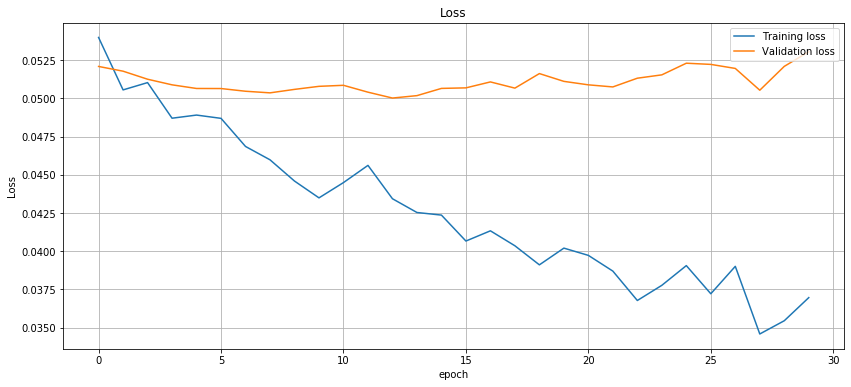

In [24]:
plot_loss(history)

In [25]:
def plot_auc(hist):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['auc'], label='Training auc')
    plt.plot(hist.history['val_auc'], label='Validation auc')
    plt.title('AUC')
    plt.legend(loc='upper right')
    plt.ylabel('auc')
    plt.xlabel('epoch')
    plt.grid()
    plt.show();

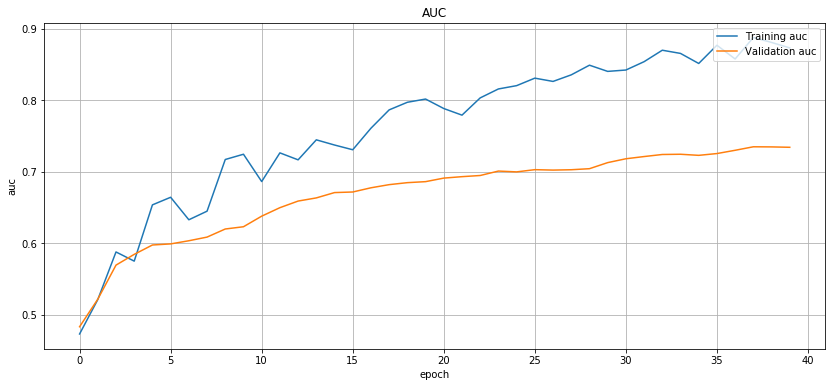

In [26]:
plot_auc(history)

In [27]:
# valuto l'AUC sul dataset di test
X_test_scaled = sc.transform(X_test)

model.evaluate(X_test_scaled, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.0319 - auc: 0.8959


[0.03187238797545433, 0.8958805799484253]

In [ ]:
# AUC: 0.8959

### Cross Validation

In [28]:
# imposto la cross validation
FOLDS = 11
VERBOSE = 0

histories = []
vet_test_auc = []

# questo è un approccio tipicamente utilizzato nelle competizioni di Kaggle
#
skf = KFold(n_splits = FOLDS, shuffle = True, random_state=1234)

for fold,(idxT,idxV) in enumerate(skf.split(X_dev_scaled, y_dev)):
    print('*** Fold num. ', fold + 1)
    
    tStart = time.time()
    
    # definisco i dataset di train e validation per questo fold
    # idxT e idxV sono gli indici da utilizzare
    fold_x_train = X_dev_scaled[idxT]
    fold_y_train = y_dev[idxT]
    
    fold_x_valid = X_dev_scaled[idxV]
    fold_y_valid = y_dev[idxV]
    
    K.clear_session()
    
    with strategy.scope():
        model = build_model(56, 40)
    
    # callback to save best model for each fold
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_loss', verbose=VERBOSE, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
    
    history = model.fit(fold_x_train, fold_y_train, epochs = 30, verbose = VERBOSE, validation_data = (fold_x_valid, fold_y_valid), callbacks = [sv])
    
    # salvo la history relativa al fold per analisi successive
    histories.append(history)
    
    max_train_auc = np.max(history.history['auc'])
    max_valid_auc = np.max(history.history['val_auc'])
    
    # valuto il modello su test
    test_loss, test_auc = model.evaluate(X_test_scaled, y_test, verbose = VERBOSE)
    
    tEnd = time.time()
    
    print('Elapsed time (sec): ', round((tEnd - tStart),1))
    print('Train AUC: ', round(max_train_auc, 4))
    print('Validation AUC: ', round(max_valid_auc, 4))
    print('Test AUC: ', round(test_auc, 4))
    print('')
    
    vet_test_auc.append(test_auc)

*** Fold num.  1
Elapsed time (sec):  5.4
Train AUC:  0.8284
Validation AUC:  0.8406
Test AUC:  0.9029

*** Fold num.  2
Elapsed time (sec):  5.4
Train AUC:  0.8492
Validation AUC:  0.7686
Test AUC:  0.9036

*** Fold num.  3
Elapsed time (sec):  5.4
Train AUC:  0.8525
Validation AUC:  0.8105
Test AUC:  0.8927

*** Fold num.  4
Elapsed time (sec):  5.7
Train AUC:  0.8394
Validation AUC:  0.8203
Test AUC:  0.8441

*** Fold num.  5
Elapsed time (sec):  5.4
Train AUC:  0.8398
Validation AUC:  0.8759
Test AUC:  0.8959

*** Fold num.  6
Elapsed time (sec):  5.5
Train AUC:  0.8302
Validation AUC:  0.8805
Test AUC:  0.9097

*** Fold num.  7
Elapsed time (sec):  5.4
Train AUC:  0.8762
Validation AUC:  0.7682
Test AUC:  0.9242

*** Fold num.  8
Elapsed time (sec):  5.7
Train AUC:  0.8228
Validation AUC:  0.745
Test AUC:  0.8883

*** Fold num.  9
Elapsed time (sec):  5.4
Train AUC:  0.8651
Validation AUC:  0.6257
Test AUC:  0.9048

*** Fold num.  10
Elapsed time (sec):  5.5
Train AUC:  0.8453
Val

In [ ]:
# dall'output si vede chiaramente che i valori di AUC dipendono dal fold (e quindi da come è scelto il validation set)
# facendo una media sugli 11 folds si ottiene un'accuratezza maggiore (ed un indicazione sulla varianza)

In [30]:
# post processing

vet_test_auc = []

for fold in range(0, FOLDS):
    # post processing
    print('Loading the best (val_auc) model of the fold...')
    model.load_weights('fold-%i.h5'%fold)
    
     # valuto il modello su test
    test_loss, test_auc = model.evaluate(X_test_scaled, y_test, verbose = VERBOSE)
    
    print('Test AUC: ', round(test_auc, 4))
    print('')
    
    vet_test_auc.append(test_auc)
    
    
avg_auc = np.mean(np.array(vet_test_auc))
std_auc = np.std(np.array(vet_test_auc))
print('Average test AUC (with std deviation): ', round(avg_auc, 4), ' +/-', round(std_auc, 4))

Loading the best (val_auc) model of the fold...
Test AUC:  0.9029

Loading the best (val_auc) model of the fold...
Test AUC:  0.8995

Loading the best (val_auc) model of the fold...
Test AUC:  0.904

Loading the best (val_auc) model of the fold...
Test AUC:  0.8441

Loading the best (val_auc) model of the fold...
Test AUC:  0.8959

Loading the best (val_auc) model of the fold...
Test AUC:  0.9097

Loading the best (val_auc) model of the fold...
Test AUC:  0.915

Loading the best (val_auc) model of the fold...
Test AUC:  0.8883

Loading the best (val_auc) model of the fold...
Test AUC:  0.9101

Loading the best (val_auc) model of the fold...
Test AUC:  0.9144

Loading the best (val_auc) model of the fold...
Test AUC:  0.8964

Average test AUC (with std deviation):  0.8982  +/- 0.0188


### Hyper parameter optimization

In [ ]:
#
# codice per la ricerca dei valori ottimali di n1, n2
#

In [ ]:

seed(1234)

tf.random.set_seed(1234)

FOLDS = 11
VERBOSE = 0

# gliglia di ricerca (è limitata per restringere il tempo)
vet_n1 = [48, 56, 64, 72, 80]
vet_n2 = [40, 48, 56, 64]

for n1 in vet_n1:
    for n2 in vet_n2:
        
        print('Elaborazione per parametri: ', n1, ',', n2)
        vet_test_auc = []
        
        skf = KFold(n_splits = FOLDS, shuffle = True, random_state=1234)

        for fold,(idxT,idxV) in enumerate(skf.split(X_dev_scaled, y_dev)):
            
            # definisco i dataset di train e validation per questo fold
            fold_x_train = X_dev_scaled[idxT]
            fold_y_train = y_dev[idxT]
    
            fold_x_valid = X_dev_scaled[idxV]
            fold_y_valid = y_dev[idxV]
    
            K.clear_session()
    
            with strategy.scope():
                model = build_model(n1, n2)
        
            history = model.fit(fold_x_train, fold_y_train, epochs = 30, verbose = VERBOSE, validation_data = (fold_x_valid, fold_y_valid), batch_size=64)
    
            # valuto il modello su test
            test_loss, test_auc = model.evaluate(X_test_scaled, y_test, verbose = VERBOSE, batch_size=64)
    
            tEnd = time.time()
    
            vet_test_auc.append(test_auc)
        
        # calcola avg_test_auc per i parametri (n1, n2)
        avg_auc = np.mean(np.array(vet_test_auc))
        std_auc = np.std(np.array(vet_test_auc))
        print('Avg test AUC: ', round(avg_auc, 4), ' +/-', round(std_auc, 4))
        print('')

### Curva ROC

In [33]:
# prendo il modello di uno dei fold: scelgo fold 10
# carico i pesi dal file
model.load_weights('fold-9.h5')

In [34]:
y_pred = model.predict(X_test_scaled)

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred)

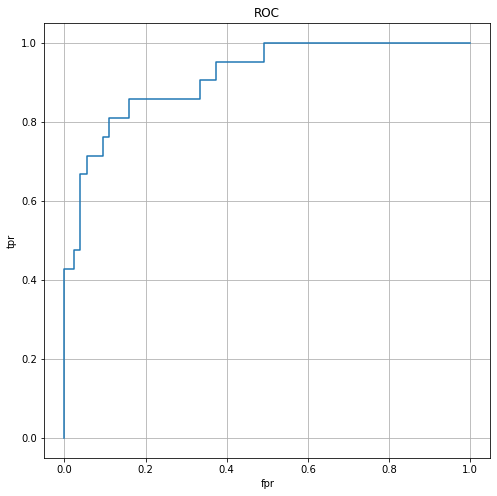

In [42]:
plt.figure(figsize=(8,8))
plt.title('ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot(fpr, tpr)
plt.grid()
plt.show()

In [84]:
X_dev

array([[3.200e+01, 4.870e+03, 2.500e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [4.100e+01, 2.430e+03, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [3.000e+01, 2.022e+03, 9.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [3.000e+01, 2.632e+03, 2.100e+01, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [4.700e+01, 2.596e+03, 8.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [2.200e+01, 4.512e+03, 2.000e+00, ..., 1.000e+00, 1.000e+00,
        0.000e+00]])

In [95]:
# modello con embedded normalization

def build_model2(n1, n2):
    
    norm = tf.keras.layers.experimental.preprocessing.Normalization()
    norm.adapt(X_dev)
    
    inputs = tf.keras.layers.Input(shape=(55,))
    
    outputs = norm(inputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="model2")
    
    model.compile(optimizer='adam', loss=[focal_loss], metrics=['AUC'])
    
    return model

In [96]:
model = build_model2(56, 40)

In [81]:
X_dev

array([[3.200e+01, 4.870e+03, 2.500e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [4.100e+01, 2.430e+03, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [3.000e+01, 2.022e+03, 9.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [3.000e+01, 2.632e+03, 2.100e+01, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [4.700e+01, 2.596e+03, 8.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [2.200e+01, 4.512e+03, 2.000e+00, ..., 1.000e+00, 1.000e+00,
        0.000e+00]])

In [73]:
adapt_data = np.array([[1.], [2.], [3.], [4.], [5.]], dtype=np.float32)
input_data = np.array([[1.], [2.], [3.]], np.float32)
layer = tf.keras.layers.experimental.preprocessing.Normalization()
layer.adapt(adapt_data)
layer(input_data)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-1.4142135 ],
       [-0.70710677],
       [ 0.        ]], dtype=float32)>

In [74]:
X_dev

array([[  32, 4870,   25, ...,    1,    0,    0],
       [  41, 2430,    2, ...,    0,    0,    1],
       [  30, 2022,    9, ...,    0,    0,    0],
       ...,
       [  30, 2632,   21, ...,    0,    0,    1],
       [  47, 2596,    8, ...,    0,    0,    1],
       [  22, 4512,    2, ...,    1,    1,    0]])